## 2023 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [51]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter
from tqdm import tqdm

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

# If you fetch_matches best to set reset=True or you may miss some events.
fetch_matches = False
reset = True
year = 2023

if fetch_matches:
    from fetchMatches import fetch_all_matches
    # This will save to matches_{year}.pkl
    fetch_all_matches(year, reset=reset)


In [52]:
# load all the matches
filename = f'matches_{year}.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)
    
# Load the aggregates
with open(f'teamStats_{year}.pkl','rb') as f:
    teamAggregates = pickle.load(f)
    
    
# Load the model
model_fn = f'model_{year}_forest.pkl'
with open(model_fn, 'rb') as f:
    vectorizer, model = pickle.load(f)

In [60]:
# For just sammamish
#event = '2023wasam'
#teams = [m.key for m in matches['event_teams'][event]]
# Do the full district
teams = set()
pnw_district = [m.key for m in matches['events'] if m.district and m.district.abbreviation=='pnw']
for e in pnw_district:
    teams=teams.union({m.key for m in matches['event_teams'][e]})

teams

{'frc1294',
 'frc1318',
 'frc1359',
 'frc1425',
 'frc1432',
 'frc1540',
 'frc1595',
 'frc1778',
 'frc1899',
 'frc1983',
 'frc2046',
 'frc2097',
 'frc2147',
 'frc2374',
 'frc2412',
 'frc2471',
 'frc2521',
 'frc2522',
 'frc2550',
 'frc2557',
 'frc2635',
 'frc2733',
 'frc2811',
 'frc2898',
 'frc2903',
 'frc2906',
 'frc2907',
 'frc2910',
 'frc2915',
 'frc2926',
 'frc2928',
 'frc2929',
 'frc2930',
 'frc2976',
 'frc2980',
 'frc2990',
 'frc3024',
 'frc3049',
 'frc3070',
 'frc3218',
 'frc3219',
 'frc3268',
 'frc3393',
 'frc3588',
 'frc360',
 'frc3636',
 'frc3663',
 'frc3673',
 'frc3674',
 'frc3681',
 'frc3711',
 'frc3712',
 'frc3786',
 'frc3826',
 'frc3876',
 'frc4043',
 'frc4060',
 'frc4061',
 'frc4089',
 'frc4104',
 'frc4125',
 'frc4127',
 'frc4131',
 'frc4173',
 'frc4180',
 'frc4450',
 'frc4469',
 'frc4488',
 'frc4512',
 'frc4513',
 'frc4579',
 'frc4662',
 'frc4681',
 'frc4682',
 'frc4692',
 'frc488',
 'frc4911',
 'frc4915',
 'frc4918',
 'frc492',
 'frc4980',
 'frc5295',
 'frc5468',
 'frc55

Now we have statistics for every team.  We can use this to generate features for every match.

In [61]:
from tqdm import tqdm
from featurization import featurizeAlliances
from itertools import combinations
features = []

self_alliances = [[t]*3 for t in teams]
alliances = []

for red,blue in combinations(self_alliances, 2):        
        f = featurizeAlliances(teamAggregates, red, blue)
        features.append(f)
        alliances.append([red,blue])
    
print(f"Running {len(features)} predictions")
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (r,b), score in zip(alliances, scores):     
    r=r[0]
    b=b[0]
    if r not in results:
        results[r] = 0
    results[r] += score[1]
    if b not in results:
        results[b] = 0
    results[b] += 1-score[1]

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(f'{r}\t{results[r]*100/len(self_alliances):0.2f}')


Running 7140 predictions
frc955	78.78
frc2930	78.52
frc2910	78.16
frc2046	78.10
frc1318	77.43
frc2147	77.10
frc3711	76.75
frc4131	76.62
frc7627	75.26
frc3218	75.24
frc2471	74.77
frc2521	73.62
frc6443	73.53
frc3636	73.47
frc7461	72.74
frc1425	72.64
frc2811	71.13
frc488	69.94
frc2990	69.02
frc2926	68.15
frc3663	67.86
frc1983	67.43
frc492	66.82
frc2522	66.48
frc1540	65.92
frc8532	63.89
frc4911	62.89
frc7034	62.51
frc3674	62.32
frc1595	61.55
frc4127	61.48
frc4061	61.45
frc4060	61.17
frc2412	61.08
frc2976	59.77
frc4915	59.72
frc4173	59.15
frc4513	57.36
frc6343	56.51
frc3826	56.25
frc5468	55.76
frc3588	55.69
frc5920	54.64
frc9023	53.56
frc4918	52.99
frc2635	52.02
frc8303	51.79
frc4692	51.32
frc4043	51.20
frc4579	51.10
frc1778	50.56
frc2557	50.47
frc4488	49.98
frc2980	49.94
frc3673	49.91
frc4980	49.27
frc360	48.59
frc4469	48.01
frc4681	47.45
frc6831	47.08
frc1432	46.87
frc2374	46.09
frc5937	45.17
frc3876	44.93
frc2906	43.76
frc1899	43.59
frc8051	43.56
frc753	43.49
frc4662	43.39
frc8032	43.21


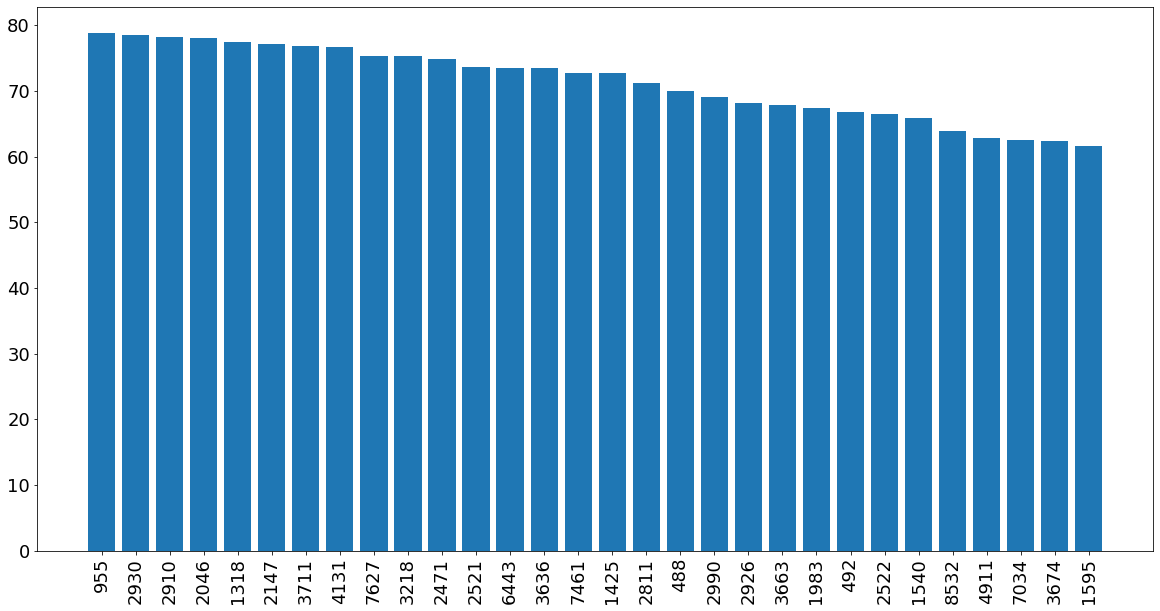

In [67]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
fig,ax = plt.subplots()
xvals = list(sorted(results, key=lambda x: results[x], reverse=True))[:30]
xlab = [x[3:] for x in xvals]
ax.bar(xlab,[results[r]*100/len(self_alliances) for r in xvals])
ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)